In [1]:
import networkx  as nx
import numpy as np
import matplotlib.pyplot as plt
import skimage.transform as st

from patrolling.agents import AgentType
from patrolling.elevation_map import *
from patrolling.graph import *
from patrolling.solvers import *
from patrolling.utility import *

# Load the graphs and visualize them with the height map

In [2]:
origin_resolution = np.load('assets/cde-b-assets/polypixel.heightmap.origin-resolution.npz')
background_grey = plt.imread('assets/cde-b-assets/polypixel.heightmap.greyscale.png')

origin = origin_resolution['origin']
resolution = origin_resolution['resolution']

ground_graph_unscaled = load_graph_from_npz('assets/cde-b-assets/polypixel_ground_graph_metric.npz')
quad_graph_unscaled = load_graph_from_npz('assets/cde-b-assets/polypixel_quad_graph_metric.npz')

In [3]:
ground_graph = shift_scale_graph(ground_graph_unscaled, origin, resolution)
quad_graph = shift_scale_graph(quad_graph_unscaled, origin, resolution)

# Load the elevation map

In [4]:
height_map = load_heightmapgrid_from_bag('assets/cde-b-assets/polypixel.heightmap.bag')

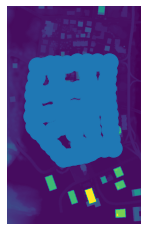

In [5]:
fig, ax = plt.subplots(1, 1)
pos = dict([(v, v) for v in ground_graph.nodes])
nx.draw(ground_graph, ax=ax, pos=pos)
ax.imshow(height_map, extent=(0, height_map.shape[1], 0, height_map.shape[0]))

# Load visibility info
## Load global visibility

In [6]:
ground_vis_scores_unnorm = np.load('assets/cde-b-assets/pp_ground_global_vis.npy')
quad_vis_scores_unnorm = np.load('assets/cde-b-assets/pp_quad_global_vis.npy')

max_vis_ground = np.max(ground_vis_scores_unnorm)
max_vis_quad = np.max(quad_vis_scores_unnorm)
max_vis_score = max(max_vis_ground, max_vis_quad)

ground_vis_map = np.flipud(st.resize(ground_vis_scores_unnorm / max_vis_score, height_map.shape))
quad_vis_map = np.flipud(st.resize(quad_vis_scores_unnorm / max_vis_score, height_map.shape))

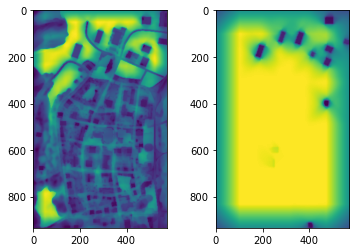

In [7]:
fig, axes = plt.subplots(1, 2)
axes[0].imshow(ground_vis_map)
axes[1].imshow(quad_vis_map)

In [8]:
kernel_size = 5
quad_vis_score_dict = build_vis_score_dict_from_vis_map(quad_graph, quad_vis_map, kernel_size)
ground_vis_score_dict = build_vis_score_dict_from_vis_map(ground_graph, ground_vis_map, kernel_size)
vis_score_dict = {AgentType.QUAD: quad_vis_score_dict,
                  AgentType.GROUND: ground_vis_score_dict}

##  Load  pointwise  visibility graphs

In [9]:
pointwise_vis = np.load('assets/cde-b-assets/pointwise_vis.npz')

In [10]:
vis_graphs = dict()

for agent_type1 in AgentType:
    vis_graphs[agent_type1] = dict()
    for agent_type2 in AgentType:
        if (agent_type1, agent_type2) == (AgentType.QUAD, AgentType.QUAD):
            vis_graph = build_vis_graph(quad_graph, pointwise_vis['ava'])
        elif (agent_type1, agent_type2) == (AgentType.QUAD, AgentType.GROUND):
            vis_graph = build_vis_graph(quad_graph, pointwise_vis['avg'])
        elif (agent_type1, agent_type2) == (AgentType.GROUND, AgentType.QUAD):
            vis_graph = build_vis_graph(quad_graph, pointwise_vis['gva'])
        else:
            vis_graph = build_vis_graph(quad_graph, pointwise_vis['gvg'])
        vis_graphs[agent_type1][agent_type2] = vis_graph

# Construct graphs with extra edges for speed

In [11]:
quad_speed = 75 * resolution
ground_speed = 50 * resolution

In [12]:
quad_graph_ws = build_graph_with_speed(quad_graph, quad_speed)
ground_graph_ws = build_graph_with_speed(ground_graph, ground_speed)
graphs = {AgentType.QUAD: quad_graph_ws,
          AgentType.GROUND: ground_graph_ws}

# Set experimental parameters

In [13]:
p_types = [AgentType.QUAD, AgentType.GROUND, AgentType.GROUND]
util_struct = {AgentType.QUAD: {'detects': 1, 'is_detected': 1},
               AgentType.GROUND: {'detects': 1, 'is_detected': 1}}
max_iters = 40

# Construct the utility matrix

In [14]:
util_fun = PvIUtilFun(vis_graphs, vis_score_dict, util_struct)
U_star = construct_star_top_util_mat(graphs, p_types, util_fun)

# Find patrolling strategies

In [15]:
def compute_ne_star_top(U_star, G_dict, p_types, use_movement_constraints=True,
                        **solver_args):
    """
    Compute an equilibrium strategy profile for a patrolling game played between
    one intruder and an arbitrary number of patrollers.

    Parameters
    ----------
    U_star : list of numpy.ndarray
        A list of utility matrices, one for each patroller.
    G_dict : dict of networkx.digraph.DiGraph
        A dictionary of graphs with <enum 'AgentType'> as keys and the graph
        represtations of the environment for the corresponding agent types as
        values.
    p_types : list of <enum 'AgentType'>
        A list of patroller agent types. One for each patroller on the team.
    use_movement_constraints : bool
        Whether to enforce the constraint on the computed policies that the
        probability of entering a node is consistent with the probability of
        leaving it. This ensures that the marginal probability of being at any
        given vertex is a consistent probability distribution.
    solver_args : **kwargs
        Additional arguments to the CVXPY solver.

    Returns
    -------
        x_list : list of numpy.ndarray
            The list of equilibrium patroller strategies. Will be the same
            length as U_star.
        y_list : list of numpy.ndarray
            The list of  equilibrium intruder strategies, one for each robot
            type as specified in the AgentType enum.
        p : np.ndarray
            The equilibrium probability distribution over the agent types
            specified in the AgentType enum for the intruder.
    """

    U = np.vstack(U_star)
    z = cp.Variable(len(U_star))
    z_vec = cp.Variable(len(U))
    w = cp.Variable()
    x_cat = cp.Variable(len(U))
    y_joint = cp.Variable(U.shape[1])
    constraints = []
    x_vars = []
    y_vars = []
    
    i = 0
    for k, U_i in enumerate(U_star):
        j = i + U_i.shape[0]
        x_vars.append(x_cat[i:j])
        constraints.append((z_vec[i:j] == z[k]))
        i = j

    for i in AgentType:
        G = G_dict[i]
        j = i * G.number_of_edges()
        k = j + G.number_of_edges()
        y_vars.append(y_joint[j:k])

    if use_movement_constraints:
        for x_var, agent_type in zip(x_vars, p_types):
            G = G_dict[agent_type]
            for v in G.nodes:
                incoming_edges = G.in_edges(v, data=True)
                outgoing_edges = G.out_edges(v, data=True)
                in_eids = [e[-1]['eid'] for e in incoming_edges]
                out_eids = [e[-1]['eid'] for e in outgoing_edges]
                in_sum = cp.sum(x_var[in_eids])
                out_sum = cp.sum(x_var[out_eids])
                constraints.append((in_sum == out_sum))
        for y_var, agent_type in zip(y_vars, AgentType):
            G = G_dict[agent_type]
            for v in G.nodes:
                incoming_edges = G.in_edges(v, data=True)
                outgoing_edges = G.out_edges(v, data=True)
                in_eids = [e[-1]['eid'] for e in incoming_edges]
                out_eids = [e[-1]['eid'] for e in outgoing_edges]
                in_sum = cp.sum(y_var[in_eids])
                out_sum = cp.sum(y_var[out_eids])
                constraints.append((in_sum == out_sum))

    constraints += [(y_joint >= 0), (cp.sum(y_joint) == 1), (x_cat >= 0)] \
                    + [(cp.sum(x_var) == 1) for x_var in x_vars]
    constraints += [(w >= -x_cat @ U), (z_vec >= U @ y_joint)]

    obj = cp.Minimize(cp.sum(z) + w)
    prob = cp.Problem(obj, constraints)
    prob.solve(**solver_args)

    x_list = [make_stable(x_var.value) for x_var in x_vars]
    p = make_stable([np.sum(y_var.value) for y_var in y_vars])
    y_list = [make_stable(y_var.value) for y_var in y_vars]

    return x_list, y_list, p

In [18]:
x_list, y_list, p = compute_ne_star_top(U_star, graphs, p_types, max_iters=40)

/home/ajlangley/anaconda3/lib/python3.8/site-packages/cvxpy/problems/problem.py:1278: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
